#  Lecture 3a MCMC

# Introduction

In this notebook we will discuss the following algorithms for estimating the posterior distribution:
- Monte Carlo based algorithms




In [172]:
using Distributions
using Turing
using StatisticalRethinking
using Random, Plots, MCMCChains

## Markov chain

#### Example
Let’s make a simulation of a chain w/ two different starting
points; one change starting at 100 and another at -27.
• The step to X(t+1) from X(t) is governed by a random number drawn
from a normalized gaussian PDF  that is
dependent on X(t):

$x(t+1)=0.9*x(t)+v(k)$ and $v(k)\sim \mathcal{N}(0, 0.19)$



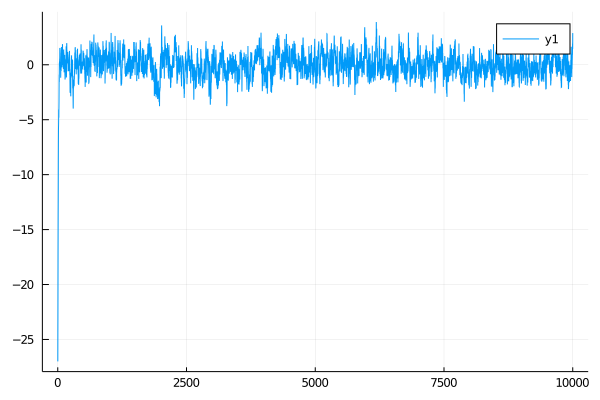

In [173]:
N=10000
x=Vector{Real}(undef, N)
x[1]=-27
for j in 2:N
   x[j]=0.9*x[j-1]+rand(Normal(0,sqrt(0.19)))
end
plot(x)


In [174]:
var(x[5000:end])

0.9223543487403022

Mean and the variance are $E(x(t))=0$ and $var(x(t))=1$

#### Example 
What is p(x(t+2)=3|p(x(t)=1)?

In [175]:
using LinearAlgebra, Statistics, StatsBase, Plots; 

n, N = 5, 10^6
Q= [0 0.5 0 0 0.5;
    0.5 0 0.5 0 0;
    0 0.5 0 0.5 0;
    0 0 0.5 0 0.5;
    0.5 0 0 0.5 0]

Q2=Q*Q
Q2[1,3]

0.25

In [176]:
Q2

5×5 Array{Float64,2}:
 0.5   0.0   0.25  0.25  0.0
 0.0   0.5   0.0   0.25  0.25
 0.25  0.0   0.5   0.0   0.25
 0.25  0.25  0.0   0.5   0.0
 0.0   0.25  0.25  0.0   0.5

What is p(x(t+h)=3|p(x(t)=1) where h=30?


In [177]:
Q30=Q
for i in 2:30
    Q30=Q30*Q
end
Q30

5×5 Array{Float64,2}:
 0.200693  0.199439  0.200214  0.200214  0.199439
 0.199439  0.200693  0.199439  0.200214  0.200214
 0.200214  0.199439  0.200693  0.199439  0.200214
 0.200214  0.200214  0.199439  0.200693  0.199439
 0.199439  0.200214  0.200214  0.199439  0.200693

If we let h be very large, then the stationary distribution has all values 0.2 meaning that there is an equal probability to be in any state.


## Metropolis Hastings

This example is from the book Statistics with Julia. Proposal distribution q is given as:
$$ \mathcal{N}(x\,;\,\mu,\sigma)=\, \frac{1}{\sigma (2\pi)^{\frac{1}{2}}} \{exp\big[ -\frac{(x-\mu)}{2\sigma^2}\big]^2 + exp\big[ -\frac{(x+\mu)}{2\sigma^2}\big]^2\}$$

MCMC Bayes Estimate: 2.065864846043017


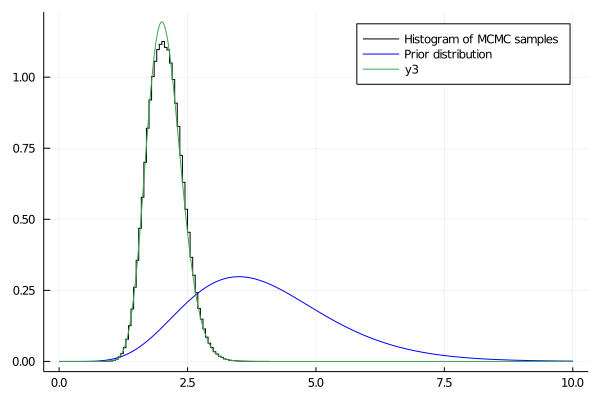

In [178]:
using Distributions, Plots

alpha, beta = 8, 2
prior(lam) = pdf(Gamma(alpha, 1/beta), lam)
data = [2,1,0,0,1,0,2,2,5,2,4,0,3,2,5,0]

like(lam) = *([pdf(Poisson(lam),x) for x in data]...)
posteriorUpToK(lam) = like(lam)*prior(lam)

sig = 0.5
foldedNormalPDF(x,mu) = (1/sqrt(2*pi*sig^2))*(exp(-(x-mu)^2/2sig^2) + exp(-(x+mu)^2/2sig^2))
foldedNormalRV(mu) = abs(rand(Normal(mu,sig)))

function sampler(piProb,qProp,rvProp)
    lam = 1
    warmN, N = 10^5, 10^6
    samples = zeros(N-warmN)

    for t in 1:N
        while true
            lamTry = rvProp(lam)
            L = piProb(lamTry)/piProb(lam)
            H = min(1,L*qProp(lam,lamTry)/qProp(lamTry,lam))
            if rand() < H
                lam = lamTry
                if t > warmN
                    samples[t-warmN] = lam
                end
                break
            end
        end
    end
    return samples
end

mcmcSamples = sampler(posteriorUpToK,foldedNormalPDF,foldedNormalRV)
println("MCMC Bayes Estimate: ",mean(mcmcSamples))

stephist(mcmcSamples, bins=100, c=:black, normed=true, label="Histogram of MCMC samples")

lamRange = 0:0.01:10
plot!(lamRange, prior.(lamRange), c=:blue, label="Prior distribution")

closedFormPosterior(lam)=pdf(Gamma(alpha + sum(data),1/(beta+length(data))),lam)
plot!(lamRange, closedFormPosterior.(lamRange))#, c=:red, label="Posterior distribution", xlims=(0, 10), ylims=(0, 1.2), xlabel="\lambda",ylabel="Density")


## Gibbs sampling
Consider the bivariate normal
model
$$(x,y)\sim \mathcal{N}(0 , \begin{bmatrix}1&\rho\\\rho&1\end{bmatrix})$$
Then,
$$y_{t+1}|x_t\sim \mathcal{N}(\rho\cdot x_t , 1-\rho^2)$$
$$x_{t+1}|y_{t+1}\sim \mathcal{N}(\rho\cdot y_{t+1} , 1-\rho^2)$$

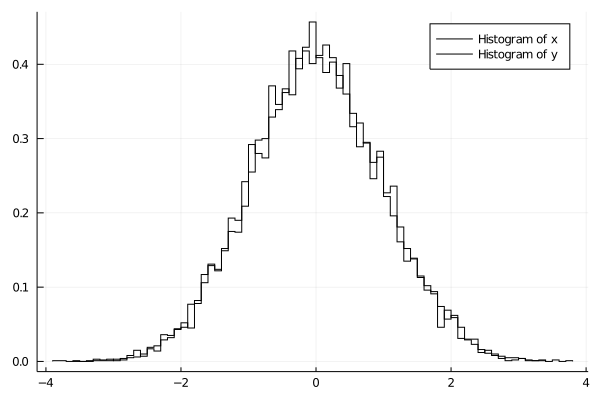

In [179]:
function bigibbs(T, rho)
    x = ones(T+1)
    y = ones(T+1)
    for t = 1:T
        x[t+1] = randn() * sqrt(1-rho^2) + rho*y[t]
        y[t+1] = randn() * sqrt(1-rho^2) + rho*x[t+1]
    end
    return x, y
end

## example
x,y=bigibbs(10000, 0.9)
stephist(x, bins=100, c=:black, normed=true, label="Histogram of x")
stephist!(y, bins=100, c=:black, normed=true, label="Histogram of y")


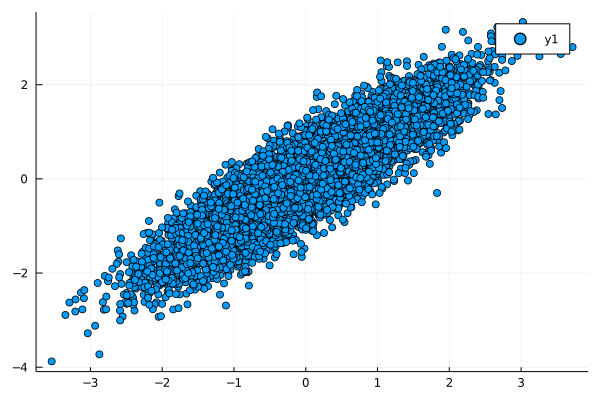

In [180]:
plot(x,y,seriestype = :scatter)

Gibbs sampling is used in modern tools like Turing:
Example:
@model gibbs_example(x) = begin
    v1 ~ Normal(0,1)
    v2 ~ Categorical(5)
end
Use PG for a ‘v2’ variable, and use HMC for the ‘v1’ variable. Note that v2 is discrete, so the PG sampler is more appropriate than is HMC.

alg = Gibbs(HMC(0.2, 3, :v1), PG(20, :v2)) 

## Diagnostics
Let us look again the simple problem of success rate from the first lecture. 


In [181]:
k=90;
n=100;
α=1
β=1
##
@model infer_rate(k,n) = begin
    # Our prior belief about the probability of heads in a coin.
    θ ~ Beta(α, β)
    # Heads or tails of a coin are drawn from a Bernoulli distribution.
    k ~ Binomial(n, θ)
end;

In [182]:
# Sampling from the model and indering the posterior distribution
#chain = sample(infer_rate(k,n), HMC(0.05, 10), 2000);
# Try MH(), HMC(0.05, 10)
chain=mapreduce(c -> sample(infer_rate(k,n),  MH(), 10000),
    chainscat,
    1:3
);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


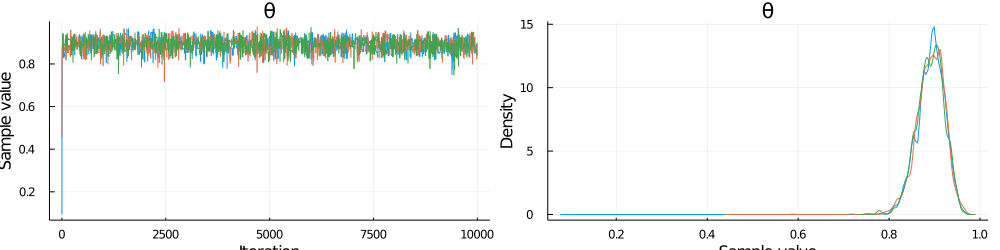

In [183]:
plot(chain)

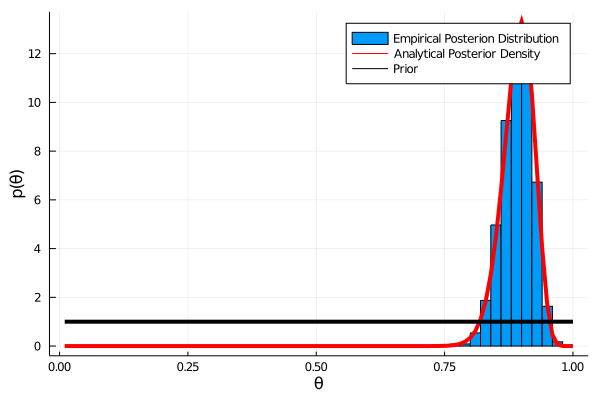

In [184]:
#Draw posterior distribution
burnin=500
p_summary = chain[:θ][burnin:end]
histogram(p_summary, xlabel="θ", bins=40, normed=true, label="Empirical Posterion Distribution")
xGrid = 0.01:0.01:1
dist=Beta.(k+α,n-k+β) 
dist_prior=Beta.(α,β) 

plot!( xGrid, pdf.(dist,xGrid), c=:red, lw=4, xlabel="θ", label="Analytical Posterior Density", ylabel = "p(θ)", legend=:topright)
plot!( xGrid, pdf.(dist_prior,xGrid), c=:black, lw=4, xlabel="θ", label="Prior", ylabel = "p(θ)", legend=:topright)


#### Autocorrelation function (ACF) 
Highly correlated MCMC samplers requires more samples to produce the same level of Monte Carlo error for an estimate. The autocorrelation function is defined as
$$\rho(l)=corr[\theta_0, \theta_l]$$ 
where $l$ is called the lag. The ACF can be computed efficiently by convolving the signal x with itself. If we plot ACF for MH and for HMC samplers we see that HMC samples are much less correlated than MH samples. 
Intuitively this indicates that each HMC sample is worth more than each MH sample.

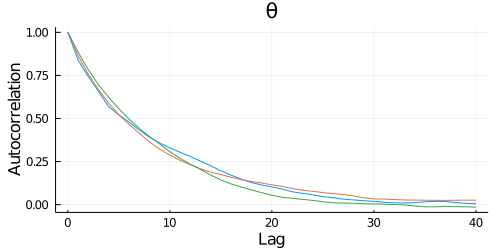

In [185]:
autocorplot(chain)

**MC error** is defined as $\sigma(\theta)/\sqrt(N)$ and it is presented as mcse.

**Effective sample size (ess)** represents the number of useful uncorelated samples in the chain. We quantify this below. Let us define autocorrelation time as  $\rho=1+2\sum_{l=1}^{\infty}\rho(l)$. 
The effective sample size is defined as the number of samples divided by the autocorrelation time:
$$N_{eff}=\frac{N}{\rho}=\frac{N}{1+2\sum_{l=1}^{\infty}\rho(l)}$$
If we truncate the sum at lag $L$ and if we run $J$ chains then the effective sample size is:
$$\hat{N}_{eff}=\frac{NJ}{\rho}=\frac{N}{1+2\sum_{l=1}^{L}\rho(l)}$$

For MH sampler, the ess=442 while for HMC is 4327.


In [186]:
display(chain)

Chains MCMC chain (10000×2×3 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 10000
parameters        = θ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           θ    0.8914    0.0305     0.0002    0.0007   1759.0029    1.0010

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           θ    0.8291    0.8727    0.8940    0.9129    0.9438


**Gelman Rubin statistics (rhat)**
If we were to start multiple parallel chains, then they should all eventually converge to the stationary distribution. So after some amount of time, it should be impossible to distinguish between the multiple chains.  One way to assess this is to compare the variation between chains to the variation within the chains. We expect that the between chain variation should be close to zero.

Let $x_1^{(j)}, x_2^{(j)},\dots$ be samples from the jth Markov chain and suppose there are J chains run in parallel with different starting values. For each chain, first discard  
D   values as “burn-in” and keep the remaining L values,  

Calculate:

\begin{eqnarray*}
\bar{x}_j 
& = &
\frac{1}{N}\sum_{t=1}^N x_t^{(j)}\hspace{2em}\text{(chain mean)}\\
\bar{x}_\cdot 
& = &
\frac{1}{J}\sum_{j=1}^J \bar{x}_j\hspace{2em}\text{(grand mean)}\\
B
& = &
\frac{N}{J-1}
\sum_{j=1}^J (\bar{x}_j-\bar{x}_\cdot)^2\hspace{2em}\text{(between chain variance)}\\
s^2_j
& = &
\frac{1}{N-1}
\sum_{t=1}^N (x_t^{(j)}-\bar{x}_j)^2\hspace{2em}\text{(within chain variance)}\\
W 
& = &
\frac{1}{J}\sum_{j=1}^J s_j^2
\end{eqnarray*}

Gelman Rubin statistics is then calculated as:
$$R = \frac{
\frac{N-1}{N}W + \frac{1}{N}B
}{W}$$

In [187]:
gelmandiag(chain)

Gelman, Rubin, and Brooks Diagnostic
  parameters      psrf     97.5% 
      Symbol   Float64   Float64 

           θ    1.0002    1.0006


## Stochastic Gradient Langevin Dynamics
We will rely on [Bayesian inference with Stochastic Gradient Langevin Dynamics](https://sebastiancallh.github.io/post/langevin/) by Sebastian Callh.
